In [1]:
import pandas as pd
import dask.dataframe as dd

import imp

prepare_data = imp.load_source('prepare_data', '../src/prepare_data.py')
process_data = imp.load_source('processe_data', '../src/process_data.py')

In [2]:
import seaborn as sns
import numpy as np
import matplotlib

In [3]:
import matplotlib.pyplot as plt

In [4]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

In [5]:
color = matplotlib.cm.viridis(0.3)

In [6]:
color_c = matplotlib.cm.viridis(0.4)

**Top perfomances**

In [7]:
dfs = []
for name in ['standard', 'noise', 'probend', 'probend_noise']:
    df = pd.read_csv('../data/%s_3_processed.csv' % name, index_col=0
                           )
    df['type'] = name
    dfs.append(df)

//anaconda3/envs/axlml/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


**Descriptive measures**

In [8]:
[df.size for df in dfs]

[37186591, 38197220, 36186840, 37192030]

In [9]:
unique_number_of_seeds = len(dfs[0].seed.unique())
unique_number_of_seeds

11420

In [10]:
file = open('../paper/unique_number_of_seeds.tex', "w")
file.write("{}".format(unique_number_of_seeds))
file.close()

In [11]:
len(dfs[0]['Name'].unique())

195

In [12]:
file = open('../paper/unique_number_of_strategies.tex', "w")
file.write("{}".format(len(dfs[0]['Name'].unique())))
file.close()

In [13]:
number_of_all_tournaments = sum([len(df.seed.unique()) for df in dfs])

In [14]:
file = open('../paper/number_of_all_tournaments.tex', "w")
file.write("{}".format(number_of_all_tournaments))
file.close()

In [15]:
summary_table = dfs[0].groupby('Name').count()['seed'].describe()
summary_table

count     195.000000
mean     5154.066667
std       187.608747
min      4693.000000
25%      5041.000000
50%      5147.000000
75%      5286.500000
max      5639.000000
Name: seed, dtype: float64

In [16]:
file = open('../paper/summary_table_of_entries.tex', "w")
file.write("{}".format(pd.DataFrame(summary_table).rename(columns={"seed": "entries"}).T.round().to_latex()))
file.close()

**Top performances tables**

In [10]:
average_prfs = []
types = []
for df in dfs:
    types.append(df['type'].unique()[0])
    average_prfs.append(df.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5))

In [11]:
columns = []
for prfs in average_prfs:
    columns.append(prfs.sort_values()[:15].index)
    columns.append(prfs.sort_values()[:15].values)

In [19]:
table = pd.DataFrame.from_records(columns,).T

In [20]:
table.columns = ['Name', r'$\bar{r}$'] * 4

In [21]:
table

,Name,$\bar{r}$,Name,$\bar{r}$,Name,$\bar{r}$,Name,$\bar{r}$
0,Evolved HMM 5,0.00667,Grumpy,0.1402,Fortress4,0.01266,Alternator,0.3037
1,Evolved FSM 16,0.00995,$e$,0.19388,Defector,0.01429,$\phi$,0.30978
2,EvolvedLookerUp2_2_2,0.01064,Tit For 2 Tats,0.20617,Better and Better,0.01587,$e$,0.3125
3,Evolved FSM 16 Noise 05,0.01667,Slow Tit For Two Tats,0.20962,Tricky Defector,0.01875,$\pi$,0.31686
4,PSO Gambler 2_2_2,0.02143,Cycle Hunter,0.21538,Fortress3,0.02174,Limited Retaliate,0.35263
5,Evolved ANN,0.02878,Risky QLearner,0.22222,Gradual Killer,0.02532,Anti Tit For Tat,0.35431
6,Evolved ANN 5,0.0339,Retaliate 3,0.22887,Aggravater,0.02778,Retaliate 3,0.35563
7,PSO Gambler 1_1_1,0.03704,Cycler CCCCCD,0.23507,Raider,0.03077,Limited Retaliate 3,0.35563
8,Evolved FSM 4,0.04891,Retaliate 2,0.23913,Cycler DDC,0.04545,Retaliate,0.35714
9,PSO Gambler Mem1,0.05036,Defector Hunter,0.24038,Hard Prober,0.05128,Retaliate 2,0.35767


In [22]:
file = open('../paper/perfomances_table.tex', "w")
file.write(table.to_latex())
file.close()

In [23]:
for prf, tps in zip(average_prfs, types):
    table = pd.DataFrame(prf.sort_values()[:15])
    table = table.rename(columns={'Normalized_Rank':
                                  r'$\bar{r}$ in %s tournaments' % tps})
    table.to_latex('../paper/performance_%s_table.tex' % tps)
    

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import gaussian_kde

%matplotlib inline

In [12]:
def get_distribution_without_outliers(distribution, percentage=0.1):
    distribution.sort()
    size_of_ditribution = len(distribution)
    outliers = int(size_of_ditribution * (percentage))
    
    return distribution[:-outliers]

**Top variation**

In [13]:
def plot_perfomance_violin_plots(type_index,
                                 tournament_type,
                                 top_names,
                                 ylim_up=1,
                                 remove_outliers=False,
                                 percentage=0.1):
    data, violin_data = [], []
    for name in top_names:
        distribution = dfs[type_index][dfs[type_index]['Name'] == name]['Normalized_Rank'].values
        
        data.append(distribution)
        
        if remove_outliers:
            distribution = get_distribution_without_outliers(distribution, percentage)
        violin_data.append(distribution)

    means = [np.mean(dt) for dt in data]

    fig, axes = plt.subplots(figsize=(10, 4))

    parts = axes.violinplot(violin_data, showextrema=False,
                            showmeans=False);

    boxes = axes.boxplot(data, showfliers=False)
    axes.scatter(range(1, len(means) + 1), means, marker='o', color='purple', zorder=3, s=50)

    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)

    for bp in boxes['medians']:
        bp.set_color('purple')
        bp.set_linewidth(2)
        bp.set_linestyle('-.')
    for bp in boxes['caps']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['whiskers']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['boxes']:
        bp.set_color('navy')
        bp.set_linewidth(2)

    axes.set_ylabel(r'$r$')
    axes.set_ylim([0, ylim_up]);
    axes.set_xticklabels(list(top_names), rotation=90);

    fig.savefig('../images/performance_%s.pdf' % tournament_type,
                bbox_inches='tight')

In [15]:
tournament_types = ['standard', 'noisy', 'probabilistic ending', 'noisy probabilistic ending']

//anaconda3/envs/axlml/lib/python3.6/site-packages/matplotlib/mathtext.py:2468: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


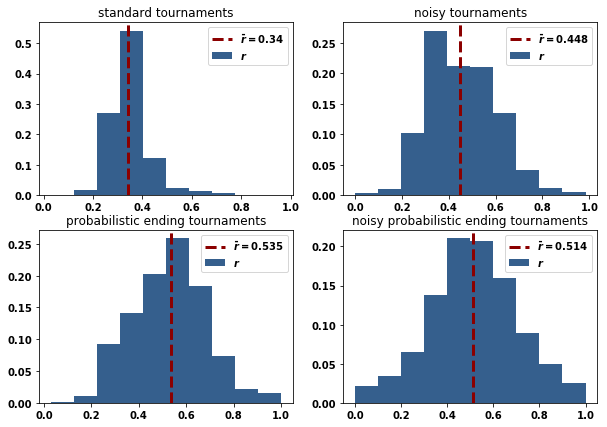

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

for i in range(4):
    index = (int(i / 2), i % 2)

    values = dfs[i][dfs[i]['Name'] == 'Tit For Tat']['Normalized_Rank'].unique()
    weights = np.ones_like(values) / float(len(values))
    axes[index].hist(values, weights=weights, color=color, label=r'$r$')
    axes[index].axvline(
        np.median(values),
        color="darkred",
        linestyle="dashed",
        linewidth=3,
        label=r"$\bar{r}=%s$" % round(np.median(values), 3),
    )
    axes[index]
    axes[index].set_title(r'%s tournaments' % tournament_types[i])
    axes[index].legend();
plt.savefig('../images/tit_for_tat_r_distributions.pdf', bbox_inches='tight')

**Standard tournaments**

In [29]:
np.mean(dfs[0]['size']), np.mean(dfs[0]['turns']), np.mean(dfs[0]['repetitions'])

(120.91104261210714, 100.92601212087443, 54.912377878359436)

In [30]:
len(dfs[0]['Name'].unique())

195

In [31]:
len(dfs[0][dfs[0]['Name'] == 'Tit For Tat'].seed.unique())

5112

In [32]:
len(dfs[0][dfs[0]['Name'] == 'Tit For Tat']['Normalized_Rank'].unique())

1358

In [33]:
np.mean(df.groupby(['Name', 'seed']).size().reset_index().groupby("Name").count()['seed'].values)

5151.364102564103

In [14]:
top_names = list(average_prfs[0].sort_values()[:15].index)

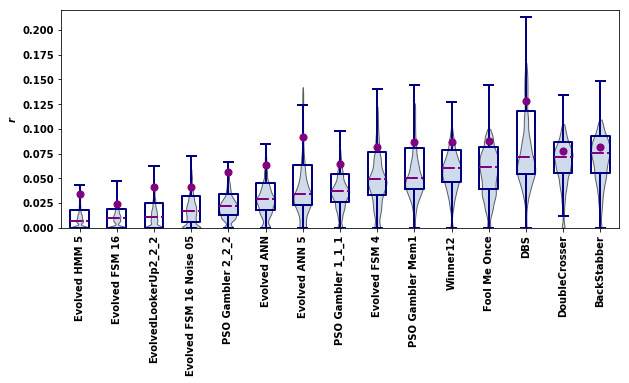

In [35]:
plot_perfomance_violin_plots(type_index=0,
                             tournament_type=types[0],
                             top_names=top_names,
                             ylim_up=0.22,
                             remove_outliers=True,
                             percentage=0.15)

**Noise**

In [36]:
np.mean(dfs[1]['size']), np.mean(dfs[1]['turns']), np.mean(dfs[1]['repetitions']), np.mean(dfs[1]['noise'])

(120.904945333718, 100.92148549030532, 54.915030989166226, 0.5035025565948674)

In [15]:
top_names_noise = list(average_prfs[1].sort_values()[:15].index)

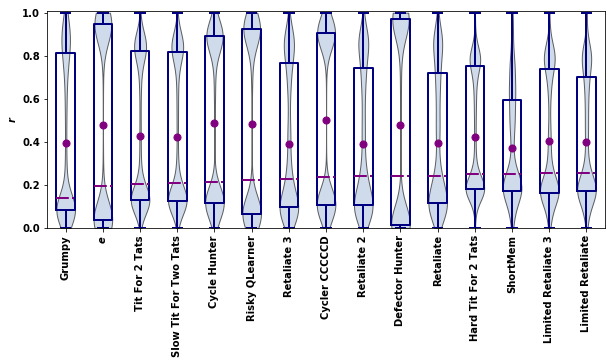

In [38]:
plot_perfomance_violin_plots(type_index=1,
                             tournament_type=types[1],
                             top_names=top_names_noise,
                             ylim_up=1.01)

**Probabilistic ending**

In [39]:
np.mean(dfs[2]['probend'])

0.4977798243241351

In [16]:
top_names_probend = list(average_prfs[2].sort_values()[:15].index)

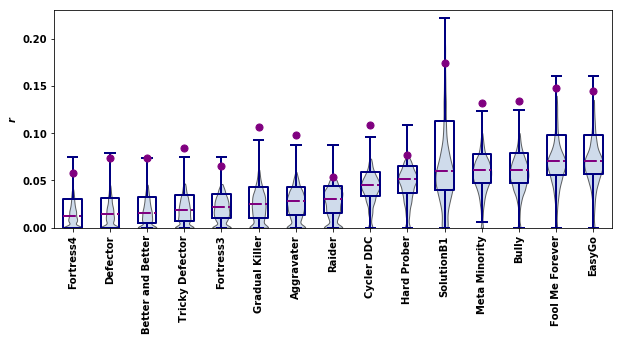

In [40]:
plot_perfomance_violin_plots(type_index=2,
                             tournament_type=types[2],
                             top_names=top_names_probend,
                             ylim_up=.23,
                             remove_outliers=True,
                             percentage=0.17)

**Probend noisy**

In [17]:
top_names_mixed = list(average_prfs[3].sort_values()[:15].index)

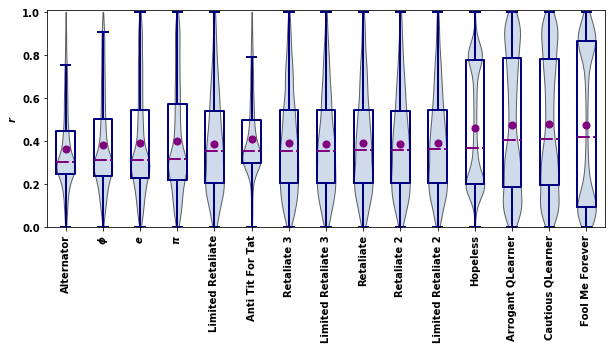

In [41]:
plot_perfomance_violin_plots(type_index=3,
                             tournament_type=types[3],
                             top_names=top_names_mixed,
                             ylim_up=1.01)

In [42]:
distributions = [dfs[-1][dfs[-1]['Name'] == name]['Normalized_Rank'].values for name in top_names_mixed]

In [43]:
import scipy.stats as stats

In [44]:
stats.f_oneway(*distributions)

F_onewayResult(statistic=124.77533668109545, pvalue=0.0)

In [45]:
s, p = stats.kruskal(*distributions)

In [46]:
p

4.365799914896071e-141

**Overall**

In [47]:
dfs_j_rank = [df[['Normalized_Rank', 'Name']] for df in dfs]

In [48]:
ranks = pd.concat(dfs_j_rank).groupby(['Name']).median()['Normalized_Rank'].round(5)

In [49]:
top_names_overall = list(ranks.sort_values()[:15].index)

In [50]:
top_names_mixed = list(average_prfs[3].sort_values()[:15].index)

In [51]:
file = open('../paper/performance_merged_table.tex', "w")
file.write(ranks.sort_values()[:15].to_latex())
file.close()

**Cooperating Ratios**

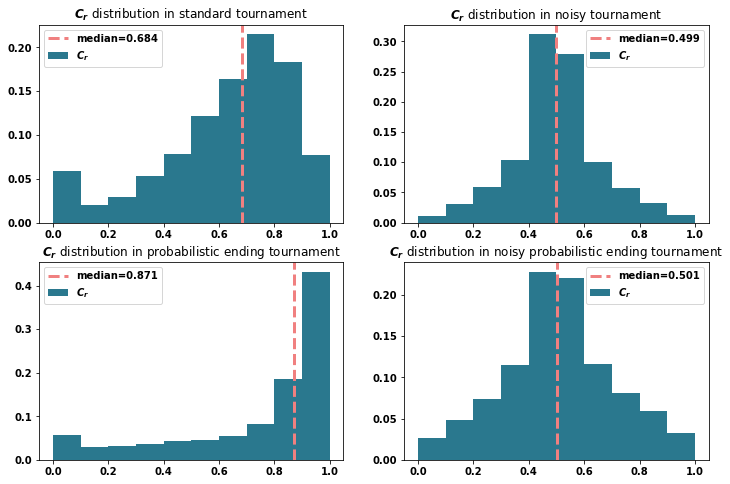

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

titles = ["standard", "noisy", "probabilistic ending", "noisy probabilistic ending"]
for i in range(4):
    index = (int(i / 2), i % 2)
    values = dfs[i]['Cooperation_rating']
    weights = np.ones_like(values) / float(len(values))
    axes[index].hist(values, weights=weights, color=color_c, label=r'$C_r$')
    axes[index].axvline(
        np.median(values),
        color="lightcoral",
        linestyle="dashed",
        linewidth=3,
        label="median=%s" % round(np.median(values), 3),
    )
    axes[index].set_title(r'$C_r$ distribution in %s tournament' % titles[i])
    axes[index].legend()
    
plt.savefig('../images/cooperation_ratings.pdf', bbox_inches='tight')

**Folk Theorem**

In [20]:
from scipy import optimize


def func(x, a, b, c):
    return a *  np.array(x) ** 2 + b * np.array(x) + c

In [21]:
colors = [matplotlib.cm.viridis_r(i) for i in np.linspace(0, 1, 6)]
linestyles = ['-', '--', '-.', ':', '']

In [22]:
transparency = [1, 1, 1, 0.5, 0.5]

//anaconda3/envs/axlml/lib/python3.6/site-packages/matplotlib/mathtext.py:2468: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


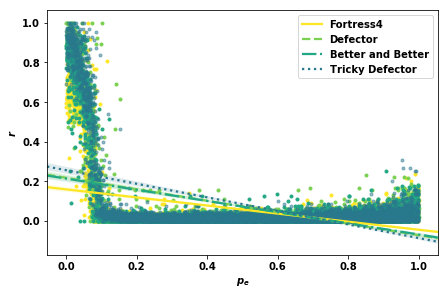

In [23]:
fig, axes = plt.subplots(figsize=(7, 4.5))
labels = []
for i, name in enumerate(top_names_probend[:4]):
    labels.append(name)
    temp = dfs[2][dfs[2]['Name'] == name]
    series = temp[['probend', 'Normalized_Rank']].groupby('probend').median()
    x = np.array(series.index)
    y = series.values
    
    x, y = pd.Series(x, name=r"$p_e$"), pd.Series(y[:, 0], name=r"$r$")
    ax = sns.regplot(x=x, y=y, color=colors[i], marker=".",
                     scatter_kws={'alpha': transparency[i]},
                     line_kws={'linestyle': linestyles[i]},
                     label=name)
    
plt.legend(loc='upper right', labels=labels)

# plt.savefig('../images/folk_theorem.pdf', bbox_inches='tight')

In [31]:
probend_val[1:2]

[0.05]

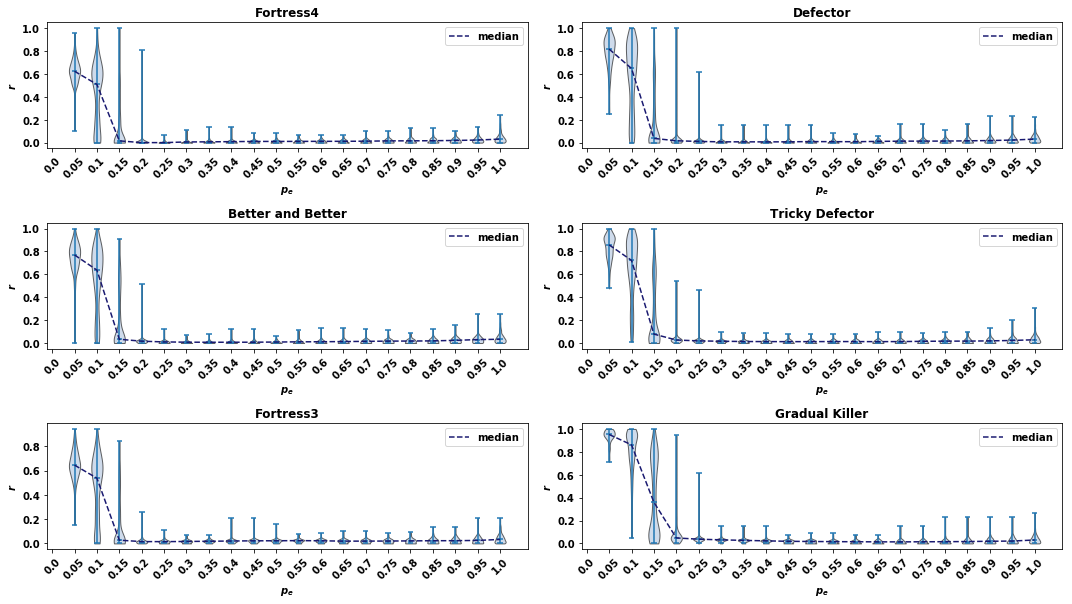

In [148]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8.5))
probend_val = np.linspace(0, 1, 21)
probend_val = [round(val, 2) for val in probend_val]
for i, name in enumerate(top_names_probend[:6]):
    temp = dfs[2][dfs[2]['Name'] == name][['probend', 'Normalized_Rank']]
    index = (int(i / 2), i % 2)
    
    distributions = []
    for j, val in enumerate(probend_val[1:]):
        if j !=0:
            distributions.append(temp[(temp['probend'] <= val) & (temp['probend'] > probend_val[j-1])]['Normalized_Rank'])
        else:
            distributions.append(temp[(temp['probend'] <= val)]['Normalized_Rank'])
    
    violin_data = [distribution.values for distribution in distributions]
    medians = [np.nan] + [np.median(distribution) for distribution in distributions]
    axes[index].plot(medians, color='midnightblue', linestyle='--', label='median')
    parts = axes[index].violinplot(violin_data, showmedians=True);
    axes[index].set_title(name, fontweight='bold')
    axes[index].set_ylabel('$r$')
    axes[index].set_xlabel('$p_e$')
    axes[index].set_xlabel('$p_e$')

    axes[index].set_xticks(range(len(probend_val)))
    axes[index].set_xticklabels(probend_val, rotation=45)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)
    axes[index].legend()
        
fig.tight_layout()
plt.savefig('../images/folk_theorem.pdf', bbox_inches='tight')

In [75]:
probend = dfs[2][dfs[2]['probend'] < 0.10]

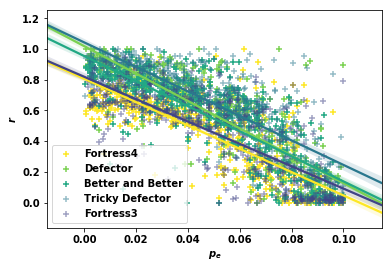

In [58]:
fig, axes = plt.subplots()
for i, name in enumerate(top_names_probend[:5]):
    temp = probend[probend['Name'] == name]
    series = temp[['probend', 'Normalized_Rank']].groupby('probend').median()
    x = np.array(series.index)
    y = series.values
    
    x, y = pd.Series(x, name=r"$p_e$"), pd.Series(y[:, 0], name=r"$r$")
    ax = sns.regplot(x=x, y=y, color=colors[i], marker="+",
                     scatter_kws={'alpha': transparency[i]}, label=name)
plt.legend();

In [76]:
len(probend['seed'].unique())

1139

In [77]:
probend.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15]

Name
Evolved FSM 16               0.00000
Evolved FSM 16 Noise 05      0.01266
MEM2                         0.02715
Evolved HMM 5                0.04423
EvolvedLookerUp2_2_2         0.04870
Spiteful Tit For Tat         0.05958
Nice Meta Winner             0.06842
NMWE Finite Memory           0.06923
Grudger                      0.06985
NMWE Deterministic           0.07018
NMWE Long Memory             0.07407
Nice Meta Winner Ensemble    0.07595
EvolvedLookerUp1_1_1         0.07692
NMWE Memory One              0.08000
NMWE Stochastic              0.08475
Name: Normalized_Rank, dtype: float64

In [109]:
table = pd.DataFrame(probend.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15])
table = table.rename(columns={'Normalized_Rank':
                              r'$\bar{r}$'})
table.to_latex('../paper/performance_probend_subset_table.tex')

In [61]:
def piecewise_linear(x, a, b, c, d, e, f):
    return np.piecewise(x, [x < 0.5, x >= 0.5], [lambda x: a *  np.array(x) ** 2 + b * np.array(x) + c,
                                                 lambda x: d *  np.array(x) ** 2 + e * np.array(x) + f])

In [185]:
colors = [matplotlib.cm.viridis(i) for i in np.linspace(0, 1, 5)]

transparency = [0.025 for _ in range(5)]

markers = ["1", "^", "o", "x", "."]

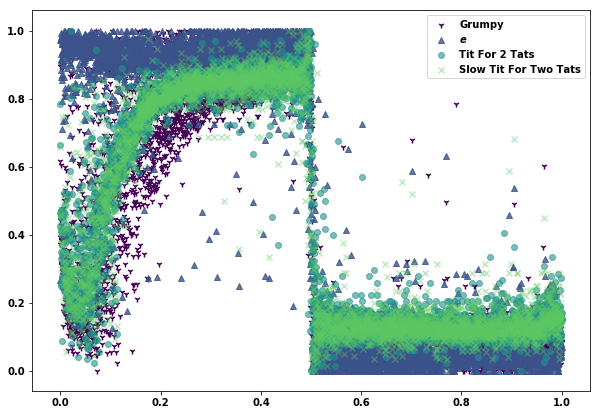

In [187]:
fig, axes = plt.subplots(figsize=(15, 8.5))
labels = []
for i, name in enumerate(top_names_noise[:4]):
    labels.append(name)
    temp = dfs[1][dfs[1]['Name'] == name]
    series = temp[['noise', 'Normalized_Rank']].groupby('noise').mean()
    x = np.array(series.index)
    y = series.values
    
    x, y = pd.Series(x, name=r"$p_n$"), pd.Series(y[:, 0], name=r"$r$")
    df = pd.DataFrame({'X': x, 'Y': y,})
    plt.scatter(x, y, color=colors[i], marker=markers[i], alpha=1 - (i *.20), label=name,)
#     ax = sns.regplot(x=x, y=y, color=colors[i], marker=".",
#                      scatter_kws={'alpha': 1 - (i *.3},
#                      line_kws={'linestyle': linestyles[i]},
#                      label=name, lowess=True)
    
plt.legend(loc='upper right', labels=labels)
plt.legend();

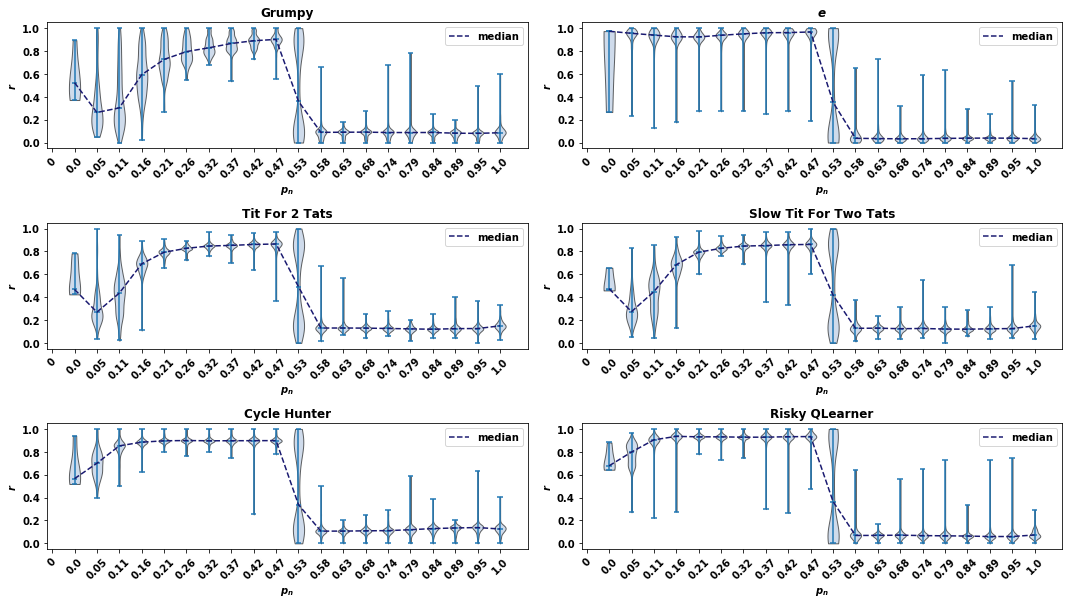

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8.5))
noise_val = np.linspace(0, 1, 20)
noise_val = [round(val, 2) for val in noise_val]
for i, name in enumerate(top_names_noise[:6]):
    temp = dfs[1][dfs[1]['Name'] == name][['noise', 'Normalized_Rank']].round({'noise': 3})
    index = (int(i / 2), i % 2)
    
    distributions = []
    for j, val in enumerate(noise_val):
        if j !=0:
            distributions.append(temp[(temp['noise'] <= val) & (temp['noise'] > noise_val[j-1])]['Normalized_Rank'])
        else:
            distributions.append(temp[(temp['noise'] <= val)]['Normalized_Rank'])
    
    violin_data = [distribution.values for distribution in distributions]
    parts = axes[index].violinplot(violin_data, showmedians=True);
    medians = [np.nan] + [np.median(distribution) for distribution in distributions]
    axes[index].plot(medians, color='midnightblue', linestyle='--', label='median')
    axes[index].set_title(name, fontweight='bold')
    axes[index].set_ylabel('$r$')
    axes[index].set_xlabel('$p_n$')
    axes[index].set_xticks(range(21))
    axes[index].set_xticklabels([0] + noise_val, rotation=45)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)
    axes[index].legend();
fig.tight_layout()

plt.savefig('../images/noise_effect.pdf', bbox_inches='tight')

In [70]:
noise = dfs[1][dfs[1]['noise'] < 0.50]

In [71]:
noise.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15]

Name
MEM2                         0.06135
Spiteful Tit For Tat         0.06344
Nice Meta Winner             0.06620
Grudger                      0.06667
Meta Winner Long Memory      0.07339
Forgiver                     0.07362
Fool Me Once                 0.07362
Meta Winner                  0.07487
Meta Winner Memory One       0.07621
Meta Winner Finite Memory    0.07692
Meta Winner Deterministic    0.07792
NMWE Deterministic           0.08696
NMWE Long Memory             0.08696
CollectiveStrategy           0.08696
Defector                     0.08889
Name: Normalized_Rank, dtype: float64

In [72]:
len(noise['seed'].unique())

5661

In [374]:
table = pd.DataFrame(noise.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15])
table = table.rename(columns={'Normalized_Rank':
                              r'$\bar{r}$'})
table.to_latex('../paper/performance_noise_subset_table.tex')

**Mixed**

In [ ]:
from scipy.interpolate import griddata

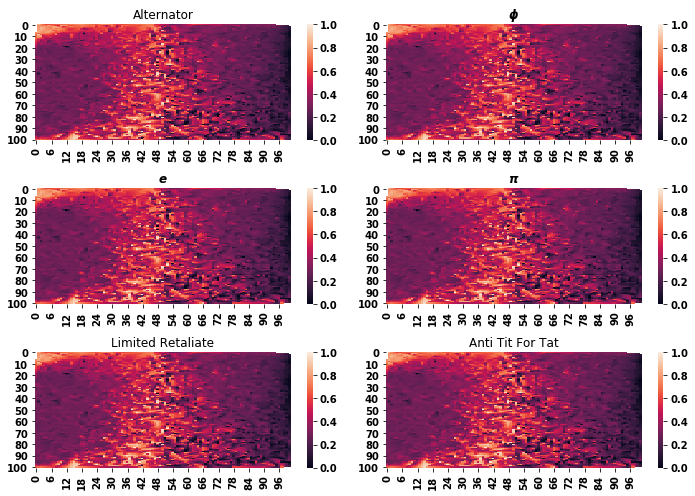

In [141]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))
for i, name in enumerate(top_names_mixed[:6]):
    mixed = dfs[3][dfs[3]['Name'] == name]
    mixed = mixed.round({'probend': 2, 'noise': 2})
    
    index = (int(i / 2), i % 2)
    
    data = mixed[['probend', 'noise', 'Normalized_Rank']]
    piv = pd.pivot_table(data, values="Normalized_Rank", 
                     index=["probend"],
                     columns=["noise"])
    
    z = piv.values
    X = piv.index
    Y = piv.columns
    
    array = np.ma.masked_invalid(z)
    xx, yy = np.meshgrid(X, Y)

    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    inter_data = interpolate.griddata((x1, y1), newarr.ravel(),
                                      (xx, yy),
                                       method='linear')
    
    sns.heatmap(GD1, ax=axes[index]);
    
    axes[index].set_title(name)
fig.tight_layout()

In [143]:
mixed = dfs[3][(dfs[3]['noise'] < 0.50) & (dfs[3]['probend'] < 0.10)]

In [144]:
mixed.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15]

Name
Defector                     0.00552
Better and Better            0.01055
Aggravater                   0.01399
Fortress4                    0.02100
Tricky Defector              0.03857
Meta Winner Long Memory      0.04878
Meta Winner Memory One       0.04955
Meta Winner Finite Memory    0.04972
Meta Winner Stochastic       0.05128
Meta Winner Deterministic    0.05195
Meta Winner                  0.05333
Meta Winner Ensemble         0.05882
Fortress3                    0.06956
CollectiveStrategy           0.07692
Prober 3                     0.08018
Name: Normalized_Rank, dtype: float64

In [147]:
len(mixed['seed'].unique())

568

In [146]:
table = pd.DataFrame(mixed.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15])
table = table.rename(columns={'Normalized_Rank':
                              r'$\bar{r}$'})
table.to_latex('../paper/performance_probend_noise_subset_table.tex')